<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

np.set_printoptions(precision = 1)

n = 50
# assume these are the original features
x1 = np.random.randint(size = n, low = 50, high = 100)
x2 = np.random.randint(size = n, low = 2, high = 20)
x3 = np.random.randint(size = n, low = 5, high = 50)

# and this is the model with some gaussian noise
y = 12 + x1 + 4 * x2 - 5 * x3 \
    + 3 * x1**2 \
    - 2 * np.sqrt(x2) \
    + 4 * np.log(x1) \
    + 2 * x1 * x3 \
    + np.random.normal(size = n, loc = 0, scale = 0.05)

# first do regression as such
X = np.column_stack((x1, x2, x3))

raw = LinearRegression()
raw.fit(X, y)
print(f'A very bad model: {raw.intercept_:.1f}', np.round(raw.coef_, 1))

# TRANSFORMATIONS
# add squares of raw features
tf1 = np.power(x1, 2)
tf2 = np.power(x2, 2)
tf3 = np.power(x3, 2)
X = np.column_stack((X, tf1, tf2, tf3))
# add roots
tf4 = np.sqrt(x1)
tf5 = np.sqrt(x2)
tf6 = np.sqrt(x3)
X = np.column_stack((X, tf4, tf5, tf6))
# add logarithms
tf7 = np.log(x1)
tf8 = np.log(x2)
tf9 = np.log(x3)
X = np.column_stack((X, tf4, tf5, tf6))
# add products
tf10 = np.multiply(x1, x2)
tf11 = np.multiply(x2, x3)
tf12 = np.multiply(x1, x3)
X = np.column_stack((X, tf10, tf11, tf12))

model = LinearRegression()
model.fit(X, y)
for (desired, obtained) in zip([12, 1, 4, -5, 3, 0, 0, 0, -2, 0, 4, 0, 0, 0, 0, 2],
                                   [round(model.intercept_)] + list([int(i) for i in np.round(model.coef_)])):
    print(desired, obtained, 'ok' if desired == obtained else 'mismatch')
    
print(f'A transformed model: {raw.intercept_:.1f}', np.round(raw.coef_, 1))

A very bad model: -20274.7 [506.5  -7.7 148.4]
12 34 mismatch
1 1 ok
4 4 ok
-5 -5 ok
3 3 ok
0 0 ok
0 0 ok
0 -2 mismatch
-2 -1 mismatch
0 0 ok
4 -2 mismatch
0 -1 mismatch
0 0 ok
0 0 ok
0 0 ok
2 2 ok
A transformed model: -20274.7 [506.5  -7.7 148.4]


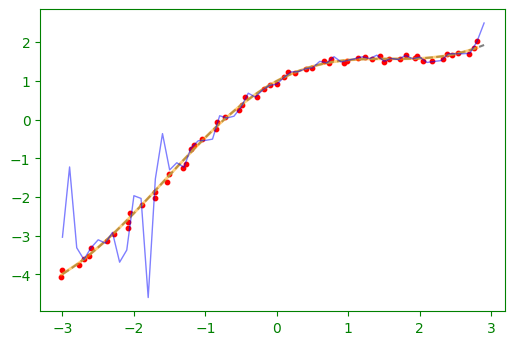

In [5]:
from scipy.interpolate import CubicSpline
from matplotlib.pyplot import figure
from numpy.random import normal
import matplotlib.pyplot as plt
import numpy as np

figure(figsize = (6, 4), dpi = 100)

xt = np.arange(-3, 3, 0.1) # true x coordinates
n = len(xt)
magnitude = 0.05
x = np.sort(xt + normal(size = n, scale = magnitude)) # add noise and SORT
yt = np.cos(xt) + xt # true y coordinates
y = yt + normal(size = n, scale = magnitude) # add noise
st = CubicSpline(xt, yt) # fit a cubic spline to the pure data
s = CubicSpline(x, y) # fit a cubic spline to the noisy data

plt.rcParams.update({'text.color': 'green',
                     'xtick.color': 'green',
                     'ytick.color': 'green',
                     'axes.labelcolor': 'green',
                     'axes.edgecolor': 'green',
                     'axes.facecolor':  'none' })
plt.scatter(x, y, c = 'red', s = 10) # data
plt.plot(xt, yt, c = 'gray', linestyle = 'dashed') # pure model
plt.plot(x, st(x), c = 'orange', linewidth = 2, alpha = 0.5) # clean spline
plt.plot(xt, s(xt), c = 'blue', linewidth = 1, alpha = 0.5) # noisy spline
plt.savefig('spline.png', transparent = True)

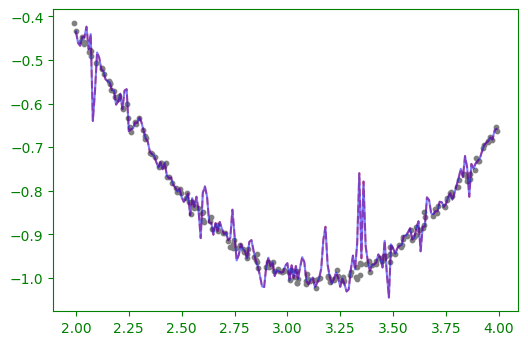

In [23]:
from scipy.interpolate import CubicSpline
from matplotlib.pyplot import figure
from numpy.random import normal
import matplotlib.pyplot as plt
import numpy as np
figure(figsize = (6, 4), dpi = 100)
xt = np.arange(2, 4, 0.01) # true x coordinates
n = len(xt)
magnitude = 0.01
x  = np.sort(xt + normal(size = n, scale = magnitude)) # add noise and SORT
y  = np.cos(xt) + normal(size = n, scale = magnitude) 
s  = CubicSpline(x, y) # as before
ns = CubicSpline(x, y, bc_type = 'natural') # fit a NATURAL cubic spline

plt.rcParams.update({'text.color': 'green',
                     'xtick.color': 'green',
                     'ytick.color': 'green',
                     'axes.labelcolor': 'green',
                     'axes.edgecolor': 'green',
                     'axes.facecolor':  'none' })
plt.scatter(x, y, c = 'gray', s = 10) # data
plt.plot(xt, s(xt), linestyle = 'dashed', c = 'red', alpha = 0.5) # regular spline (defaults to 'not-a-knot')
plt.plot(xt, ns(xt), c = 'blue', alpha = 0.5) # natural spline

plt.savefig('natural.png', transparent = True)

## Regresión lineal en predicción de demanda eléctrica

A continuación aplicaremos técnicas de expansión de base aplicados a predicción de demanda eléctrica por regresión, tal como se hizo en el la [tarea 3](https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea3.ipynb#scrollTo=Ext-myaET2n5). Recordando que la variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación. Compararemos el desempeño de usar transformación variables y algunas tpecnicas de reducción de dimensiones como **stepwise**.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)